# Determination of bias in angle reconstruction

The determination of angles in our images is biased, since we apply binning as well as non-rectangular pixels. Let's try to emulate it.

Strategy:
- Throw a few "cosmics" of constant length and varying orientation on a quadratic grid
- apply binning
- try our reconstruction

In [215]:
import numpy as np
# Set up matplotlib and use a nicer set of plot parameters
%config InlineBackend.rc = {}
import matplotlib
matplotlib.rc_file("../templates/matplotlibrc")
import matplotlib.pyplot as plt
%matplotlib inline

import scipy.ndimage as ndimage

In [216]:
def add_cosmics(image, n, l):
    # add n cosmics of length l (in pixels) and random angles onto the image
    # the image corresponds to a cosmic ray mask output of, say, scrappy
    # cosmics are added to the image - also returns a list of angles
    
    # get image dimensions
    (xmax,ymax) = image.shape
    xmax -= 1
    ymax -= 1
    
    # roll some angles
    angles = np.random.uniform(low=0,high=2*np.pi,size=n)
    
    # starting from the origin point, construct the cosmics
    for ii in range(n):
        # roll origin points
        x0 = np.random.randint(0,xmax,size=1)
        y0 = np.random.randint(0,ymax,size=1)
        
        # roll affected pixels
        x = np.linspace(x0, x0+(l*np.cos(angles[ii])),2*l)  # 2*l to avoid skipping pixels
        y = np.linspace(y0, y0+(l*np.sin(angles[ii])),2*l)
        # round to nearest ints
        x = np.floor(x).astype("int")                       # floor makes sense here - (0.5,0.5) is pixel (0,0)
        y = np.floor(y).astype("int")
        
        # remove everything going over border
        x_cut = x[np.logical_and(x<xmax, y<ymax)]
        y_cut = y[np.logical_and(x<xmax, y<ymax)]
        
        # fill the affected pixels
        image[x_cut,y_cut] = 1
        
    angles[angles>np.pi/2] -= np.pi # rebin to what we can detect
    return angles*180/np.pi         # in degrees

In [217]:
source = np.zeros((2543*2,990*6)) # like SM, but no binning and rectangular pixels
#source = np.zeros((100,100))

In [218]:
angles = add_cosmics(source,1000,5)

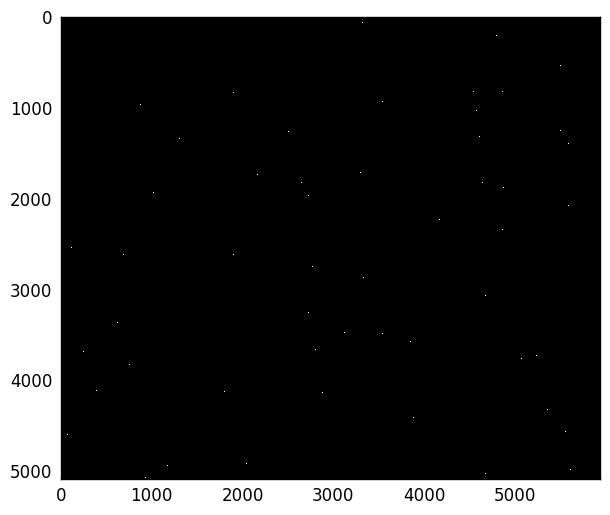

In [219]:
plt.imshow(source,cmap="gray")
plt.grid(False)

In [220]:
def bin_array_old(image, binx, biny):
    # rebin, using the maximum in each rectangle
    
    (xmax,ymax) = image.shape
    x_new = int(xmax/binx)
    y_new = int(ymax/biny)
    
    output = np.zeros((x_new,y_new,binx*biny))
    delx = np.arange(0,xmax,binx)
    dely = np.arange(0,ymax,biny)
    
    for ix in range(x_new):
        for iy in range(y_new):
            x0 = delx[ix]
            y0 = dely[iy]
            output[ix,iy,:] = image[x0:x0+binx,y0:y0+biny].flatten()
               
    return np.max(output,axis=2)

In [221]:
def bin_array(image, binx, biny):
    # rebin, using the maximum in each rectangle
    
    (xmax,ymax) = image.shape
    x_new = int(xmax/binx)
    y_new = int(ymax/biny)
    
    
    delx = np.arange(0,xmax,binx)
    dely = np.arange(0,ymax,biny)
    
    output = np.zeros((x_new,y_new))
    binned_x = np.zeros((x_new,ymax))
    
    # first the maxima along x
    for ix in range(x_new):
        x0 = delx[ix]
        binned_x[ix,:] = np.max(image[x0:x0+binx,:],axis=0)
    # then along y
    for iy in range(y_new):
        y0 = dely[iy]
        output[:,iy] = np.max(binned_x[:,y0:y0+biny],axis=1)
        
    return output

# Appearance in SM

In [222]:
binx = 2
biny = 6

source_sm = bin_array(source,binx,biny)
mask = source_sm

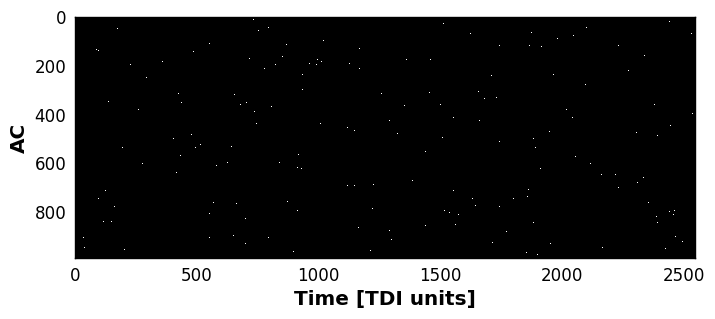

In [223]:
image=np.flip(np.rot90(source_sm,1),0) # this should follow the normal gaia convention
plt.xlabel('Time [TDI units]')
plt.ylabel('AC')
plt.imshow(image, cmap='gray')
plt.grid(False)

In [224]:
# labelling
(labels, ntracks) = ndimage.measurements.label(mask, structure=(np.ones((3,3))))

# object extraction
evtlocs = ndimage.measurements.find_objects(labels)

print(ntracks, "Events")

993 Events


In [225]:
# Extract track lengths. We can use the slices for that

lengths = np.zeros(ntracks)
lx = np.zeros(ntracks)
ly = np.zeros(ntracks)

covered = 0   # amount of cosmic pixels

for ii in range(ntracks):
    # unit: \mu m
    dx = evtlocs[ii][0].stop-evtlocs[ii][0].start
    dy = evtlocs[ii][1].stop-evtlocs[ii][1].start

    lx[ii] = (dx-1)*binx               # to roughly account for the binning
    ly[ii] = (dy-1)*biny               # need to subtract 1, since single pixel cosmics would then have
                                    # a length of sqrt(2)
    covered += dx*dy

lengths = np.sqrt(lx**2 + ly**2)
#lhist = plt.hist(lengths,30)
#plt.title("Track Lengths")

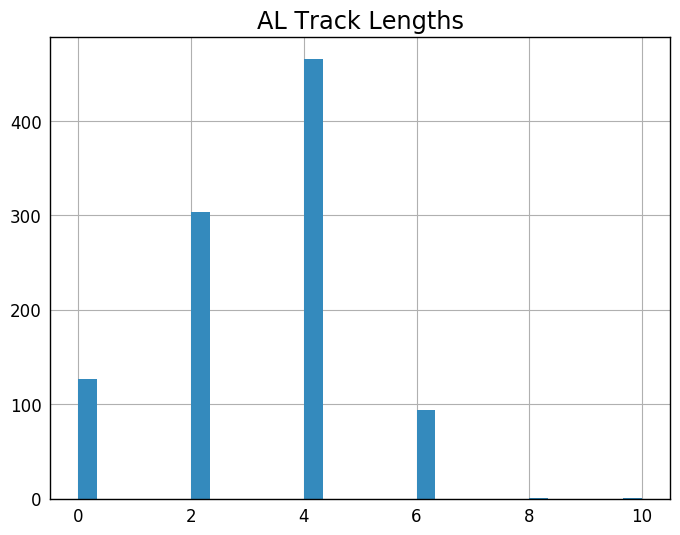

In [226]:
xhist = plt.hist(lx,30)
plt.title("AL Track Lengths")

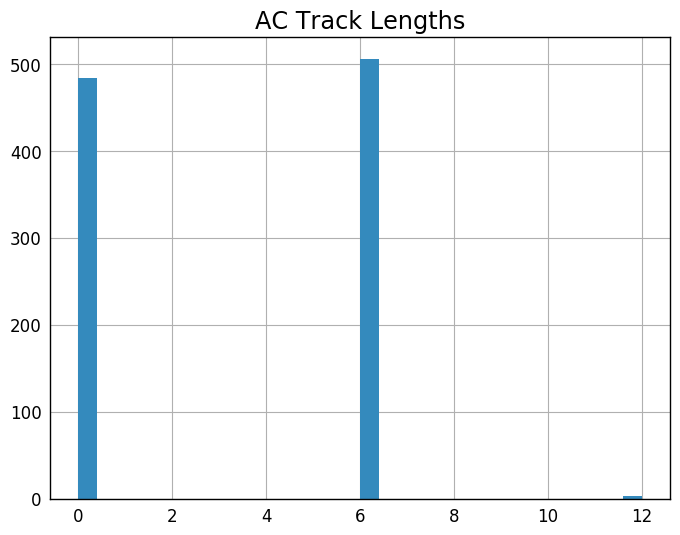

In [227]:
yhist = plt.hist(ly,30)
plt.title("AC Track Lengths")

In [228]:
theta = np.zeros(lx.shape)

nonzero = np.logical_and(lx!=0, ly!=0)
theta[nonzero] = np.arctan(ly[nonzero]/lx[nonzero])*180/np.pi

theta[lx==0] = 90  # 90
theta[ly==0] = 0  # 0
theta[np.logical_and(lx==0, ly==0)] = 5000  # ignore for now

# if the UPPER LEFT CORNER of the event has a cosmic, it faces downwards
# this only works for cosmics that have angles not 0 or 90 deg
for ii in range(len(lx)):
    if (lx*ly)[ii]!=0:
        if mask[evtlocs[ii]][0,0]==1:
            theta[ii] *= -1

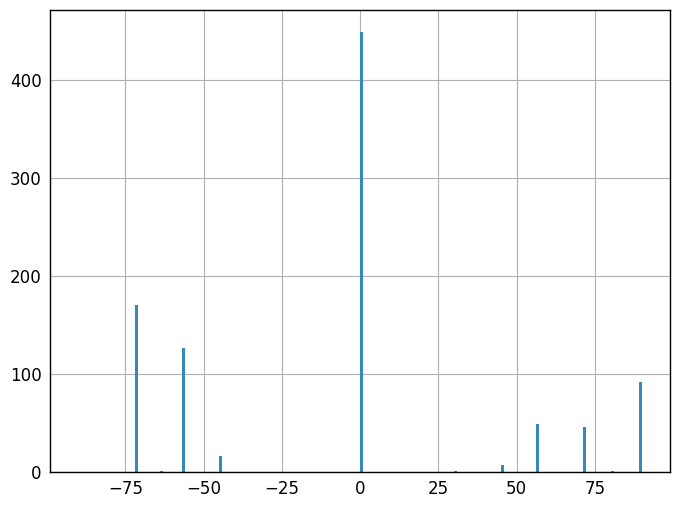

In [229]:
thist = plt.hist(theta,180,range=(-90,90))

# Appearance in BAM

In [230]:
binx = 1
biny = 12

source_bam = bin_array(source,binx,biny)
mask = source_bam

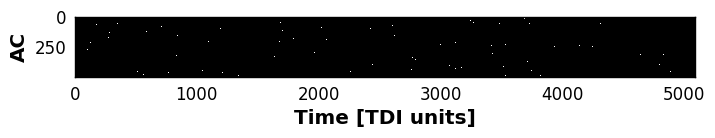

In [237]:
image=np.flip(np.rot90(source_bam,1),0) # this should follow the normal gaia convention
plt.xlabel('Time [TDI units]')
plt.ylabel('AC')
plt.imshow(image, cmap='gray')
plt.grid(False)

In [231]:
# labelling
(labels, ntracks) = ndimage.measurements.label(mask, structure=(np.ones((3,3))))

# object extraction
evtlocs = ndimage.measurements.find_objects(labels)

print(ntracks, "Events")

993 Events


In [232]:
# Extract track lengths. We can use the slices for that

lengths = np.zeros(ntracks)
lx = np.zeros(ntracks)
ly = np.zeros(ntracks)

covered = 0   # amount of cosmic pixels

for ii in range(ntracks):
    # unit: \mu m
    dx = evtlocs[ii][0].stop-evtlocs[ii][0].start
    dy = evtlocs[ii][1].stop-evtlocs[ii][1].start

    lx[ii] = (dx-1)*binx               # to roughly account for the binning
    ly[ii] = (dy-1)*biny               # need to subtract 1, since single pixel cosmics would then have
                                    # a length of sqrt(2)
    covered += dx*dy

lengths = np.sqrt(lx**2 + ly**2)
#lhist = plt.hist(lengths,30)
#plt.title("Track Lengths")

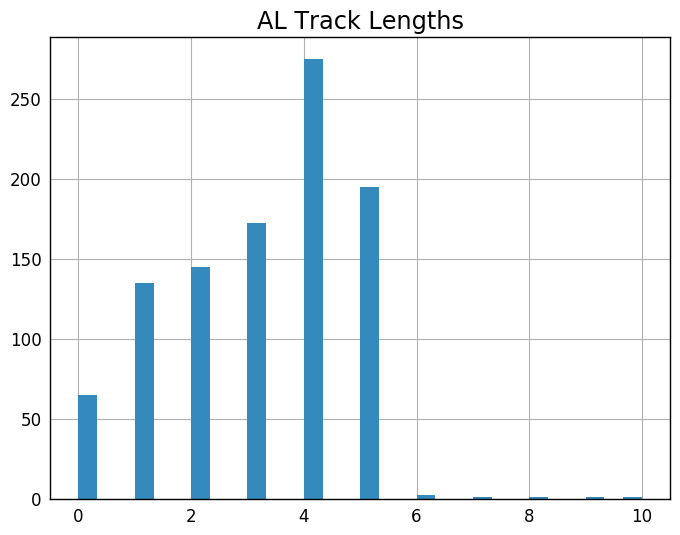

In [233]:
xhist = plt.hist(lx,30)
plt.title("AL Track Lengths")

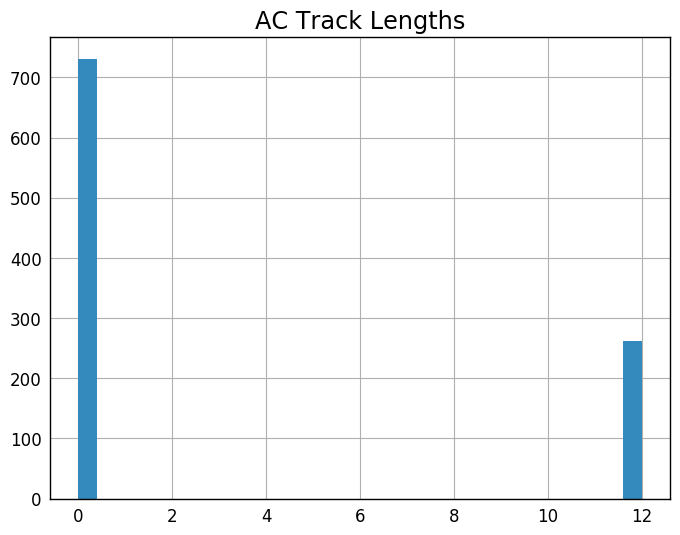

In [234]:
yhist = plt.hist(ly,30)
plt.title("AC Track Lengths")

In [235]:
theta = np.zeros(lx.shape)

nonzero = np.logical_and(lx!=0, ly!=0)
theta[nonzero] = np.arctan(ly[nonzero]/lx[nonzero])*180/np.pi

theta[lx==0] = 90  # 90
theta[ly==0] = 0  # 0
theta[np.logical_and(lx==0, ly==0)] = 5000  # ignore for now

# if the UPPER LEFT CORNER of the event has a cosmic, it faces downwards
# this only works for cosmics that have angles not 0 or 90 deg
for ii in range(len(lx)):
    if (lx*ly)[ii]!=0:
        if mask[evtlocs[ii]][0,0]==1:
            theta[ii] *= -1

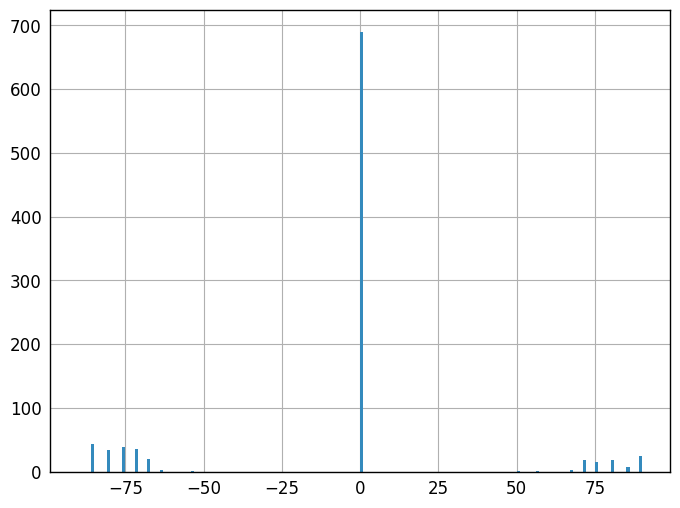

In [236]:
thist = plt.hist(theta,180,range=(-90,90))

# Aside from some systematics in my rebinning and such, this matches very well!